In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import scipy
from scipy.linalg import hadamard
import scipy.signal
import pylab
from scipy.misc import derivative

# Set up helper functions

In [2]:
def set_walsh_sim(N, n, stepperiod, verify=False):
        """
        N: order of walsh matrix
        n: walsh index to give this stream
        stepperiod: period (2^?), in multiples of self.periodbase FPGA clocks,
        of shortest walsh step. I.e., 2**13 * 2**self.baseperiod * N
        = period of complete cycle in FPGA clocks.
        """
        depth = 2**12
        N_round = int(2**(np.ceil(np.log2(N))))
        walsh_matrix = hadamard(N_round)
        # reformat so 1 means multiply by -1, and 0 means multiply by 1
        walsh_matrix[walsh_matrix == 1]  = 1
        walsh_matrix[walsh_matrix == -1] = -1
        walsh_func = walsh_matrix[n] # a vector of length N_round
        walsh_func_stretch = walsh_func.repeat(2**stepperiod) # a vector of length N_round * 2*step_period
        return walsh_func_stretch

def spectrometer(timestream, sampling_rate, fft_length, num_spectra_integration):
    """
    Create a spectrometer for a given timestream.

    Parameters:
    - timestream: The input time-domain signal.
    - sampling_rate: The sampling rate of the timestream.
    - fft_length: The length of the FFT.
    - num_spectra_integration: The number of spectra to integrate for each result.

    Returns:
    - frequencies: Array of frequencies.
    - integrated_spectra: List of integrated magnitude spectra.
    """
    num_samples = len(timestream)
    num_segments = int(num_samples / (sampling_rate * num_spectra_integration))
    
    frequencies = np.fft.fftfreq(fft_length, d=1/sampling_rate)[:fft_length//2]
    spectra = []
    integrated_spectra = []

    for i in range(num_segments):
        start_index = i * fft_length
        end_index = start_index + fft_length
        segment = timestream[start_index:end_index]
        
        # Perform FFT
        spectrum = np.fft.fft(segment)[:fft_length//2]
        magnitude_spectrum = np.abs(spectrum)
        spectra.append(magnitude_spectrum)
        
    spectra = np.reshape(spectra,(num_segments,-1))
    
    print(spectra.shape)
    # Integrate the spectra
    for i in range(num_segments//num_spectra_integration):
        start_index = (i)*num_spectra_integration 
        end_index = (i+1)*num_spectra_integration 
        integrated_spectra.append(np.sum(spectra[start_index:end_index],axis=1))

    return frequencies, spectra

def correlator(timestream0, timestream1, sampling_rate, fft_length, num_spectra_integration):
    """
    Create a correlator for a given timestream.

    Parameters:
    - timestream0: The first input time-domain signal.
    - timestream1: The second input time-domain signal.   
    - sampling_rate: The sampling rate of the timestream.
    - fft_length: The length of the FFT.
    - num_spectra_integration: The number of spectra to integrate for each result.

    Returns:
    - frequencies: Array of frequencies.
    - integrated_spectra: List of integrated correlation
    """
    num_samples = len(timestream0)
    num_segments = int(num_samples / (sampling_rate * num_spectra_integration))
    
    frequencies = np.fft.fftfreq(fft_length, d=1/sampling_rate)[:fft_length//2]
    integrated_correlations = []

    for i in range(num_segments):
        start_index = i * int(sampling_rate * num_spectra_integration)
        end_index = start_index + fft_length * num_spectra_integration
        segment0 = timestream0[start_index:end_index]
        segment1 = timestream1[start_index:end_index]
        
        # Perform FFT
        spectrum0 = np.fft.fft(segment0)[:fft_length//2]
        spectrum1 = np.fft.fft(segment1)[:fft_length//2]
        correlation = abs(spectrum0*spectrum1)
        
        # Integrate the spectra
        integrated_correlation = np.sum(np.reshape(correlation, (num_spectra_integration, -1)), axis=0)
        integrated_correlations.append(integrated_correlation)

    return frequencies, integrated_correlations

# Generate Walsh Patterns 

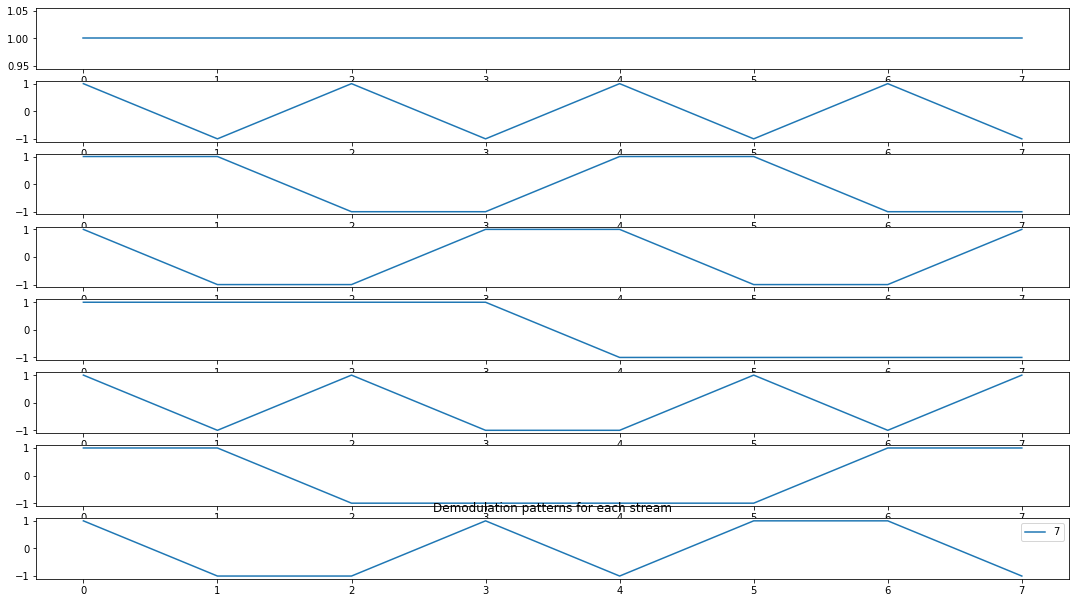

In [3]:
#Generate walsh patterns of a length 8, which could be used for 8 seperate time streams
fig,ax = plt.subplots(8,1)
fig.set_size_inches(18.5, 10.5)
for i in range(8):
    ax[i].plot(set_walsh_sim(8,i,0), label=i)
plt.title('Demodulation patterns for each stream')
plt.legend()
plt.show()

# Can we recover a signal?

In [4]:
sampling_rate = 1024  # Hz
duration = 1000  # seconds
t = np.arange(0, duration, 1/sampling_rate)
cw_signal = np.sin(2 * np.pi * 20 * t) 
cw_signal2 = np.sin(2 * np.pi * 40 * t) 

noise = np.random.normal(loc=0, scale=1, size=len(t)) 
data = noise + cw_signal

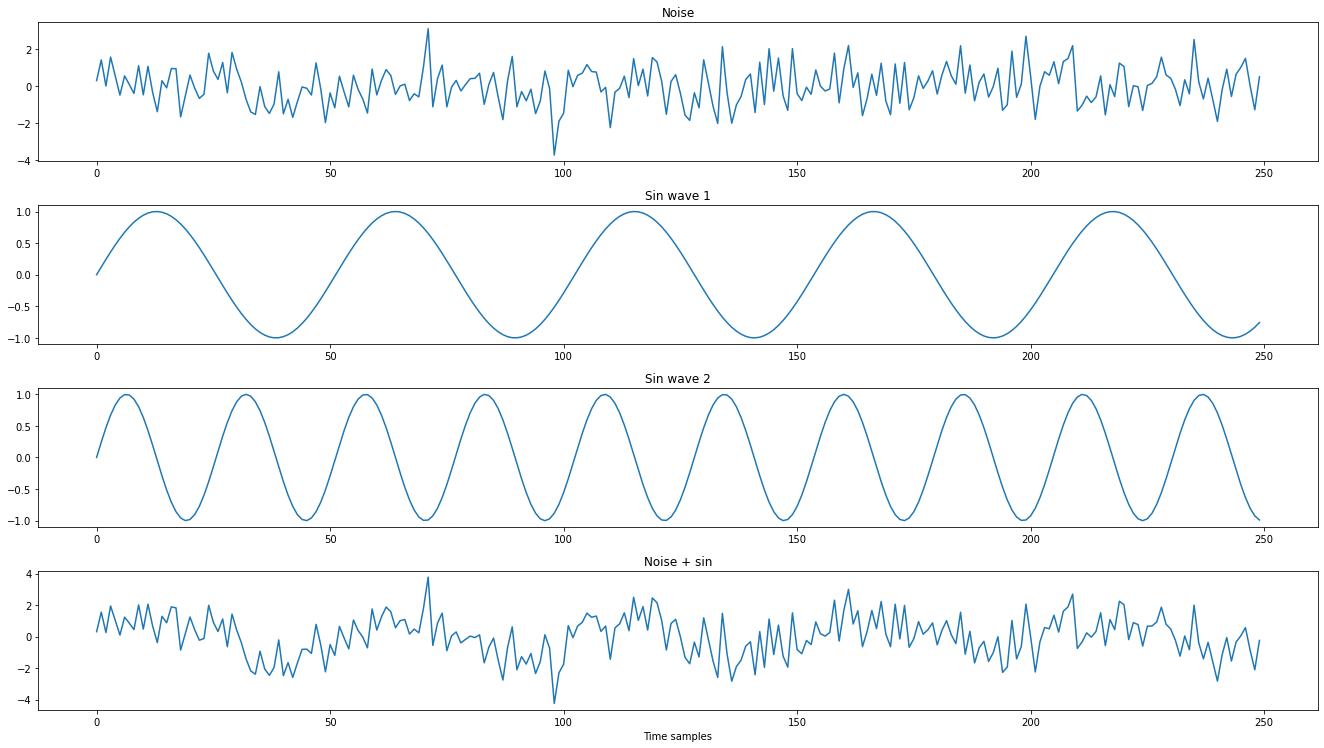

In [5]:
fig,ax = plt.subplots(4,1)
fig.set_size_inches(18.5, 10.5)

plt.subplot(4,1,1)
plt.title("Noise")
plt.plot(noise[:250])
plt.subplot(4,1,2)
plt.title("Sin wave 1")
plt.plot(cw_signal[:250])
plt.subplot(4,1,3)
plt.title("Sin wave 2")
plt.plot(cw_signal2[:250])
plt.subplot(4,1,4)
plt.title("Noise + sin")
plt.plot(data[:250])
plt.xlabel("Time samples")
plt.tight_layout()
plt.show()

/home/jhub_admin/src/anaconda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


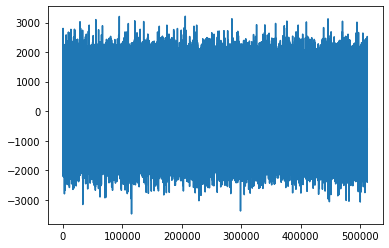

In [6]:
plt.plot(np.fft.rfft(data))

# Modulate test data stream 

In [7]:
#extend the number of samples for the walsh function to match the signal length 
period_base = len(t)//8
n= 0
n2 = period_base
walsh0 = set_walsh_sim(8,1,0)
walsh0extended = np.zeros(len(t))
for i in range(len(walsh0)):
    extended = np.array(walsh0[i].repeat(period_base))
    walsh0extended[n:n2] = extended
    n += period_base
    n2 += period_base

In [8]:
n = 0
n2 = period_base
walsh1 = set_walsh_sim(8,2,0)
walsh1extended = np.zeros(len(t))
for i in range(len(walsh1)):
    extended = np.array(walsh1[i].repeat(period_base))
    walsh1extended[n:n2] = extended
    n += period_base
    n2 += period_base

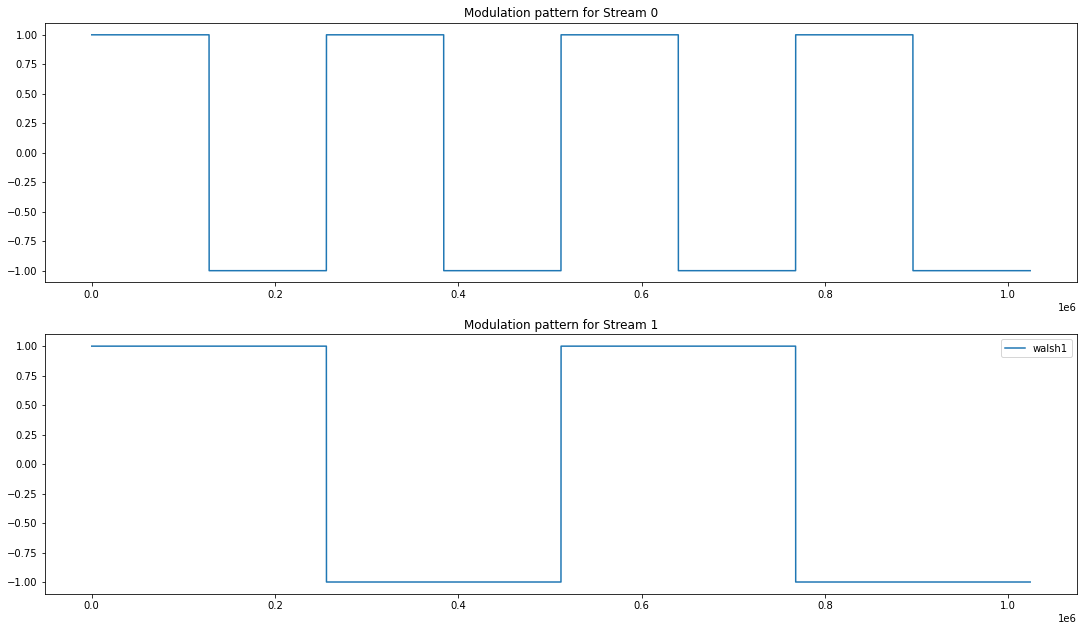

In [9]:
fig,ax = plt.subplots(2,1)
fig.set_size_inches(18.5, 10.5)
ax[0].set_title('Modulation pattern for Stream 0')
ax[1].set_title('Modulation pattern for Stream 1')
ax[0].plot(walsh0extended, label='walsh0')
ax[1].plot(walsh1extended, label='walsh1')
#ax[i].set_xlim(0,10)
plt.legend()
plt.show()

check orthogonality

In [10]:
np.sum(walsh0extended*walsh1extended)

0.0

In [11]:
modulated0 = np.zeros(len(walsh0extended))
modulated1 = np.zeros(len(walsh1extended))
for i in range(len(walsh0extended)):
    if walsh0extended[i] == 1:
        modulated0[i] = data[i]
    if walsh0extended[i] == -1:
        modulated0[i] = -data[i]

for i in range(len(walsh1extended)):
    if walsh1extended[i] == 1:
        modulated1[i] = data[i]
    if walsh1extended[i] == -1:
        modulated1[i] = -data[i]

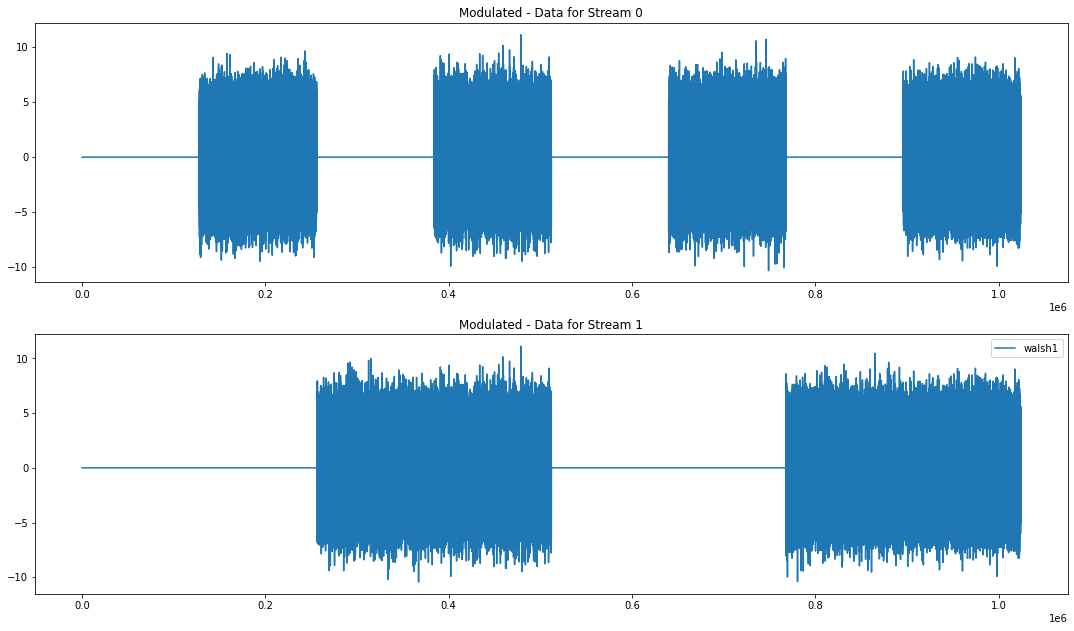

In [12]:
fig,ax = plt.subplots(2,1)
fig.set_size_inches(18.5, 10.5)
ax[0].set_title('Modulated - Data for Stream 0')
ax[1].set_title('Modulated - Data for Stream 1')
ax[0].plot(modulated0-data, label='walsh0')
ax[1].plot(modulated1-data, label='walsh1')
plt.legend()
plt.show()

# Demodulate

In [13]:
demodulated0 = np.zeros(len(walsh0extended))
demodulated1 = np.zeros(len(walsh1extended))
for i in range(len(walsh0extended)):
    if walsh0extended[i] == 1:
        demodulated0[i] = modulated0[i]
    if walsh0extended[i] == -1:
        demodulated0[i] = -modulated0[i]

for i in range(len(walsh1extended)):
    if walsh1extended[i] == 1:
        demodulated1[i] = modulated1[i]
    if walsh1extended[i] == -1:
        demodulated1[i] = -modulated1[i]

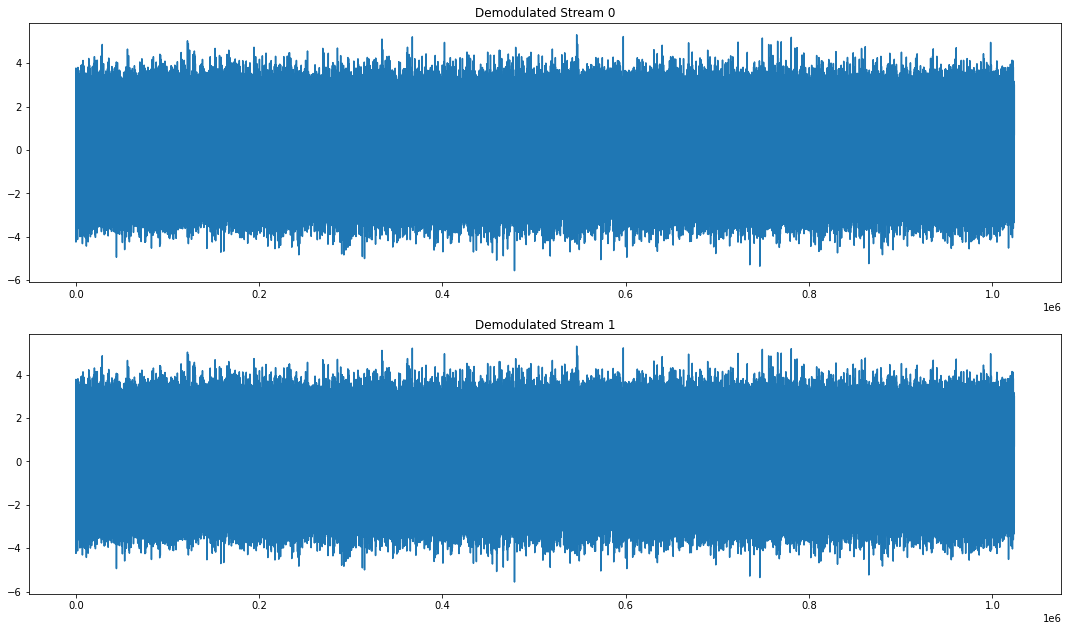

In [14]:
fig,ax = plt.subplots(2,1)
fig.set_size_inches(18.5, 10.5)
ax[0].set_title('Demodulated Stream 0')
ax[1].set_title('Demodulated Stream 1')
ax[0].plot(demodulated0, label='walsh0')
ax[1].plot(demodulated1, label='walsh1')
#ax[i].set_xlim(0,10)
plt.show()

do we get the same result back?

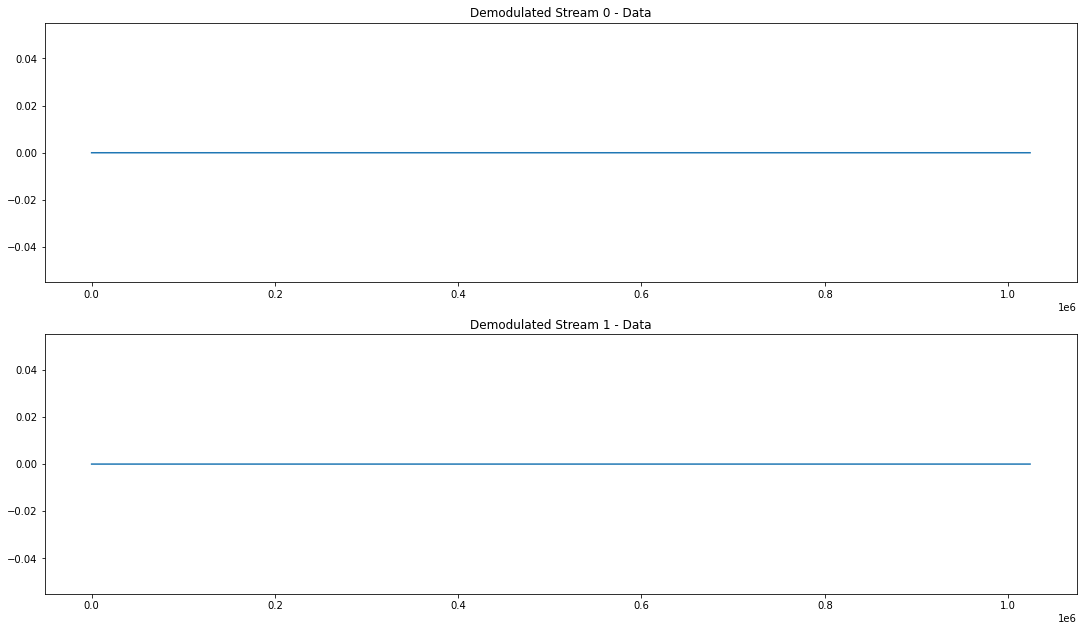

In [15]:
fig,ax = plt.subplots(2,1)
fig.set_size_inches(18.5, 10.5)
ax[0].set_title('Demodulated Stream 0 - Data')
ax[1].set_title('Demodulated Stream 1 - Data')
ax[0].plot(demodulated0-data, label='walsh0')
ax[1].plot(demodulated1-data, label='walsh1')
#ax[i].set_xlim(0,10)
plt.show()

# Code up Equation from Thompson

Let U(t) be an unwanted system response, and U1(t) be the mean residual spurious voltage

In [16]:
def mrsv(T,M, u_m):
   return(T**m/(2**(math.factorial(M)))*derivative(u_m))

# Try to replicate Emerson ALMA Memo 537 

In [17]:
walsh_matrix = hadamard(32)
# reformat so 1 means multiply by -1, and 0 means multiply by 1
walsh_matrix[walsh_matrix == 1]  = 1
walsh_matrix[walsh_matrix == -1] = -1

Generate the first 32 walsh functions

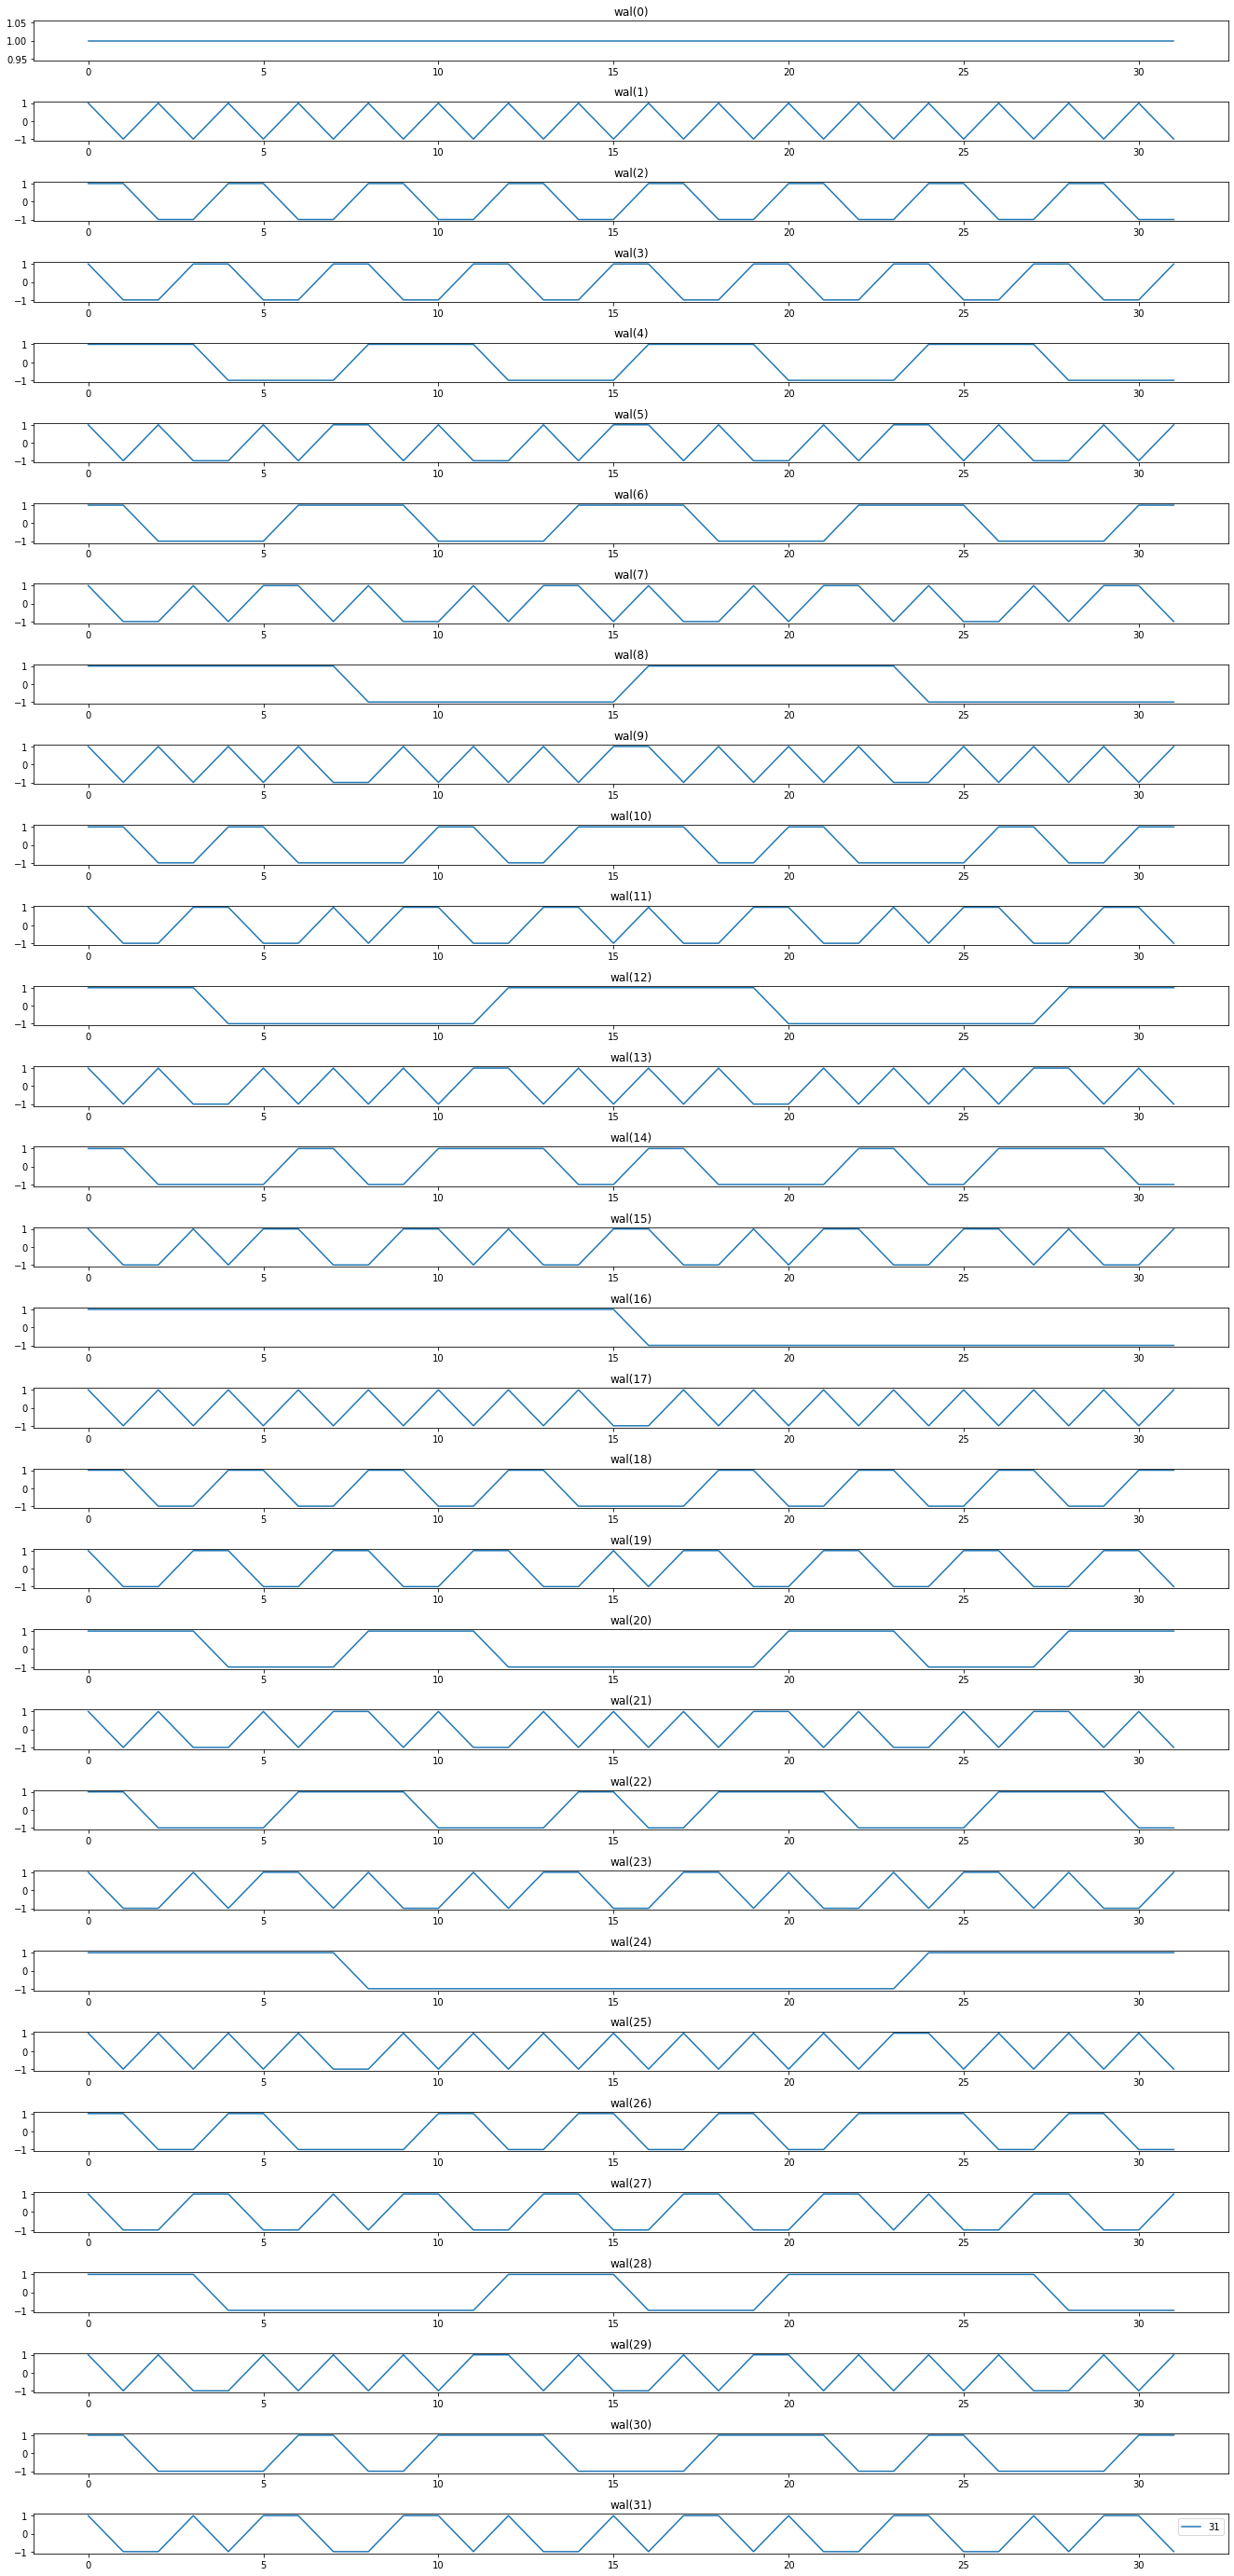

In [18]:
#Generate walsh patterns of a length 8, which could be used for 8 seperate time streams
fig,ax = plt.subplots(32,1)
fig.set_size_inches(18.5, 38.5)
for i in range(32):
    ax[i].plot(walsh_matrix[i], label=i)
    ax[i].set_title('wal('+str(i)+')')
plt.legend()
plt.tight_layout()
plt.show()

oversample the functions by 100 

In [19]:
#extend the number of samples for the walsh function to match the signal length 
print(walsh_matrix.shape)
period_base = 100
walshextended = np.zeros((32,3200))
print(walshextended.shape)
for i in range(32):
    n= 0
    n2 = period_base
    for j in range(32):
        extended = np.array(walsh_matrix[i][j].repeat(period_base))
        walshextended[i][n:n2] = extended
        n += period_base
        n2 += period_base

(32, 32)
(32, 3200)


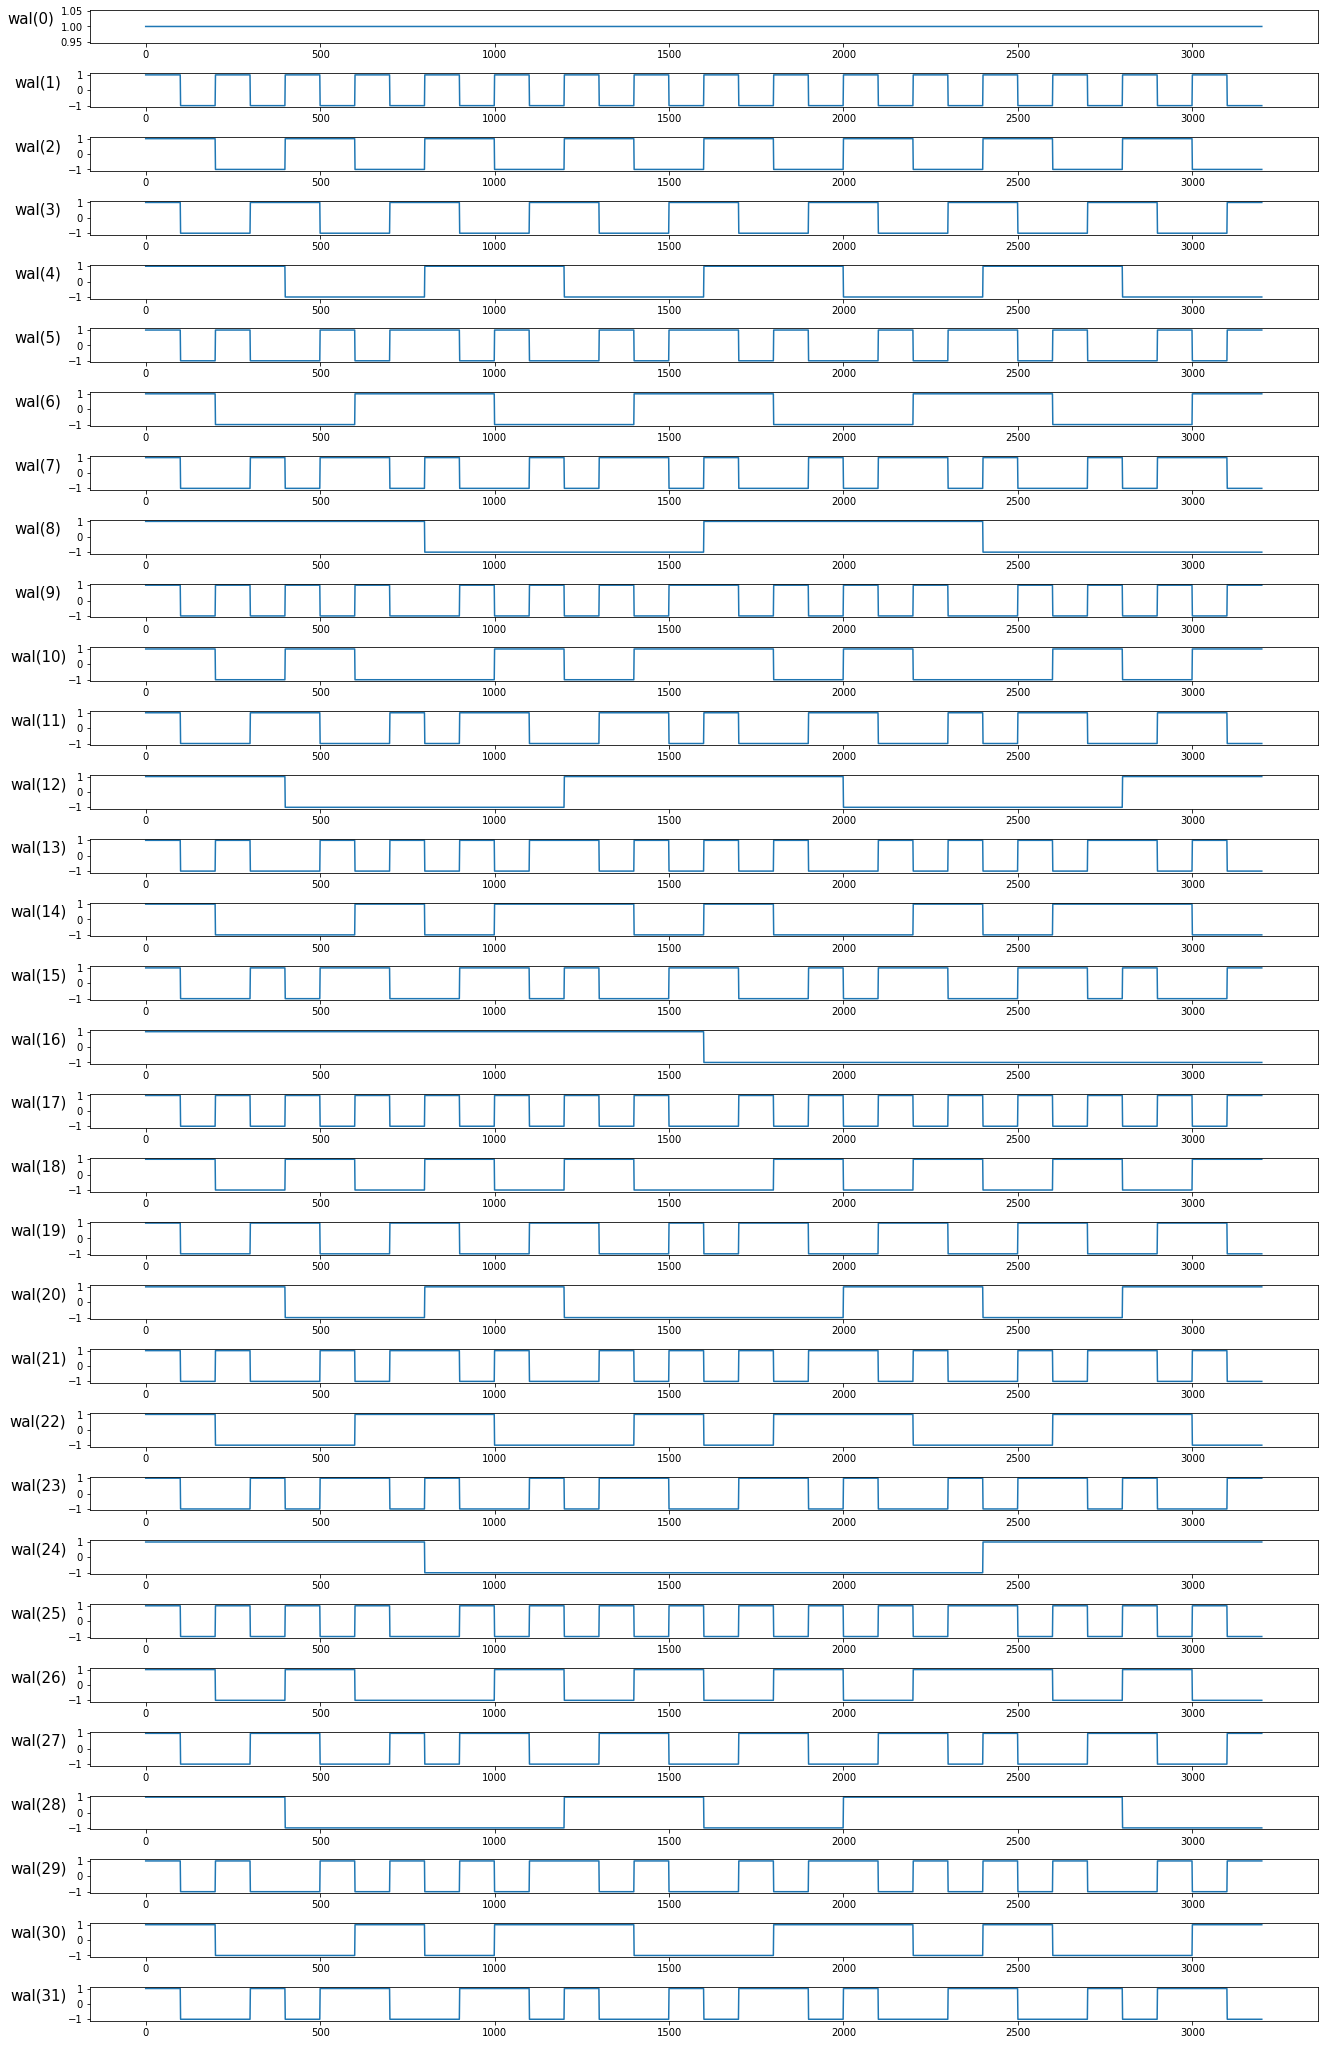

In [20]:
fig,ax = plt.subplots(32,1)
fig.set_size_inches(18.5, 28.5)
for i in range(32):
    ax[i].plot(walshextended[i])
    #ax[i].set_title('wal('+str(i)+')')
    ax[i].set_ylabel('wal('+str(i)+')', rotation=0, labelpad=30, fontsize=15)
plt.tight_layout()
plt.savefig('walsh_first_32.pdf',format='pdf')
plt.show()

reorder by number of zero crossings

In [21]:
sequency = {}
for i in range(32):
    wal_ind = ((walshextended[i][:-1] * walshextended[i][1:]) < 0).sum()
    sequency[wal_ind] = walshextended[i]
    
    
sorted_walsh = [sequency[key] for key in sorted(sequency)]

sorted_inds = []
for i in range(32):
    wal_ind = ((sorted_walsh[i][:-1] * sorted_walsh[i][1:]) < 0).sum()
    sorted_inds.append(wal_ind)

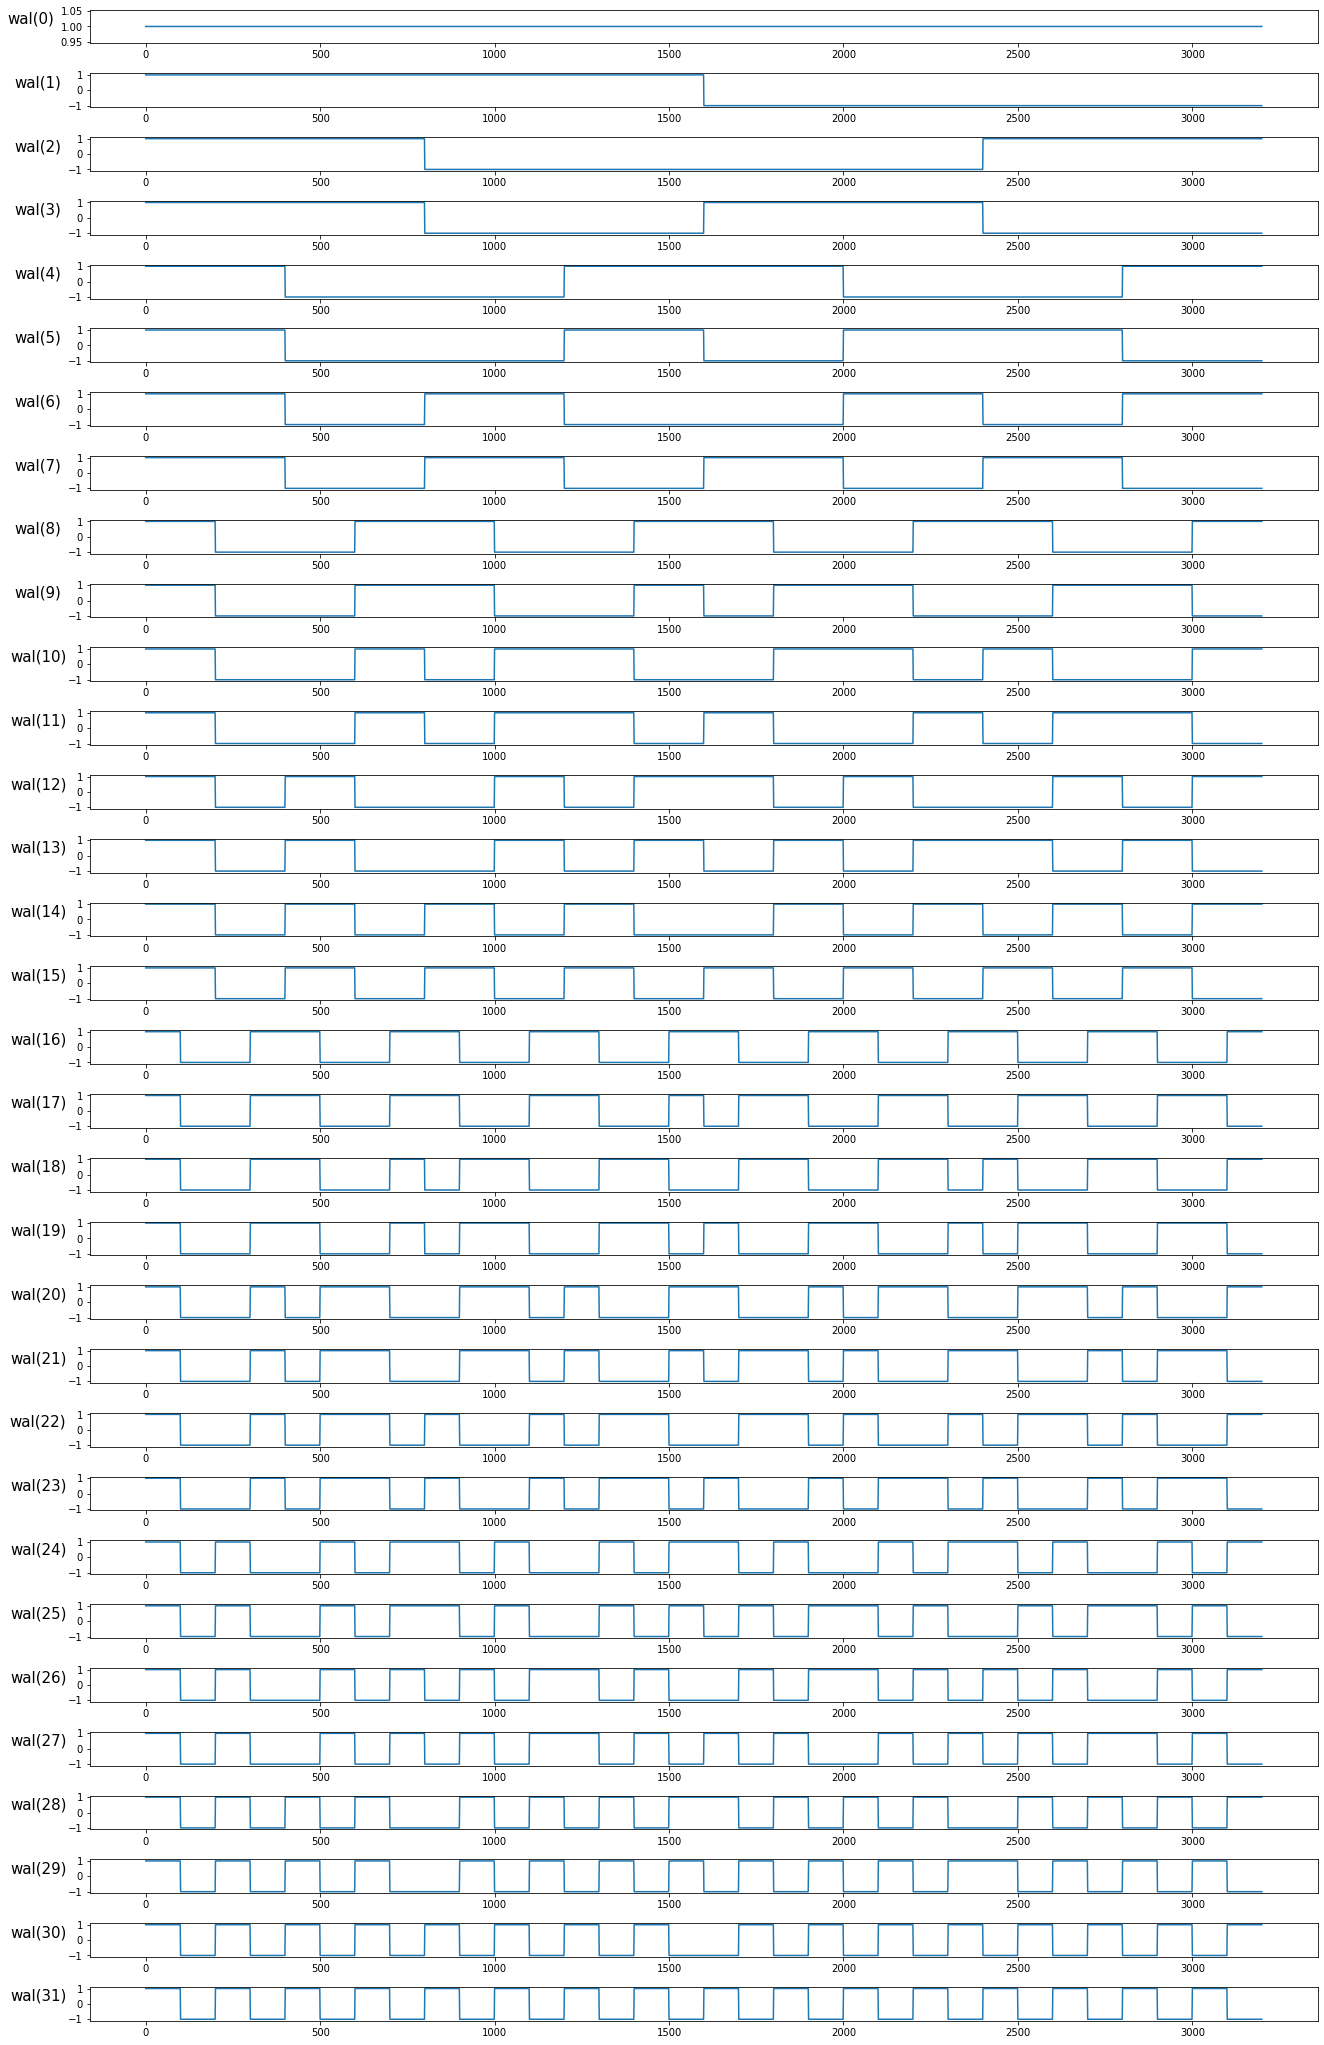

In [22]:
fig,ax = plt.subplots(32,1)
fig.set_size_inches(18.5, 28.5)
for i in range(32):
    ax[i].plot(sorted_walsh[i])
    ax[i].set_ylabel('wal('+str(i)+')', rotation=0, labelpad=30, fontsize=15)

plt.tight_layout()
plt.savefig('walsh_first_32_sequency.pdf',format='pdf')

copy the signal so we can time shift 

In [23]:
copy = sorted_walsh 
doubled = np.concatenate((sorted_walsh, copy), axis=1)
print(doubled.shape)

(32, 6400)


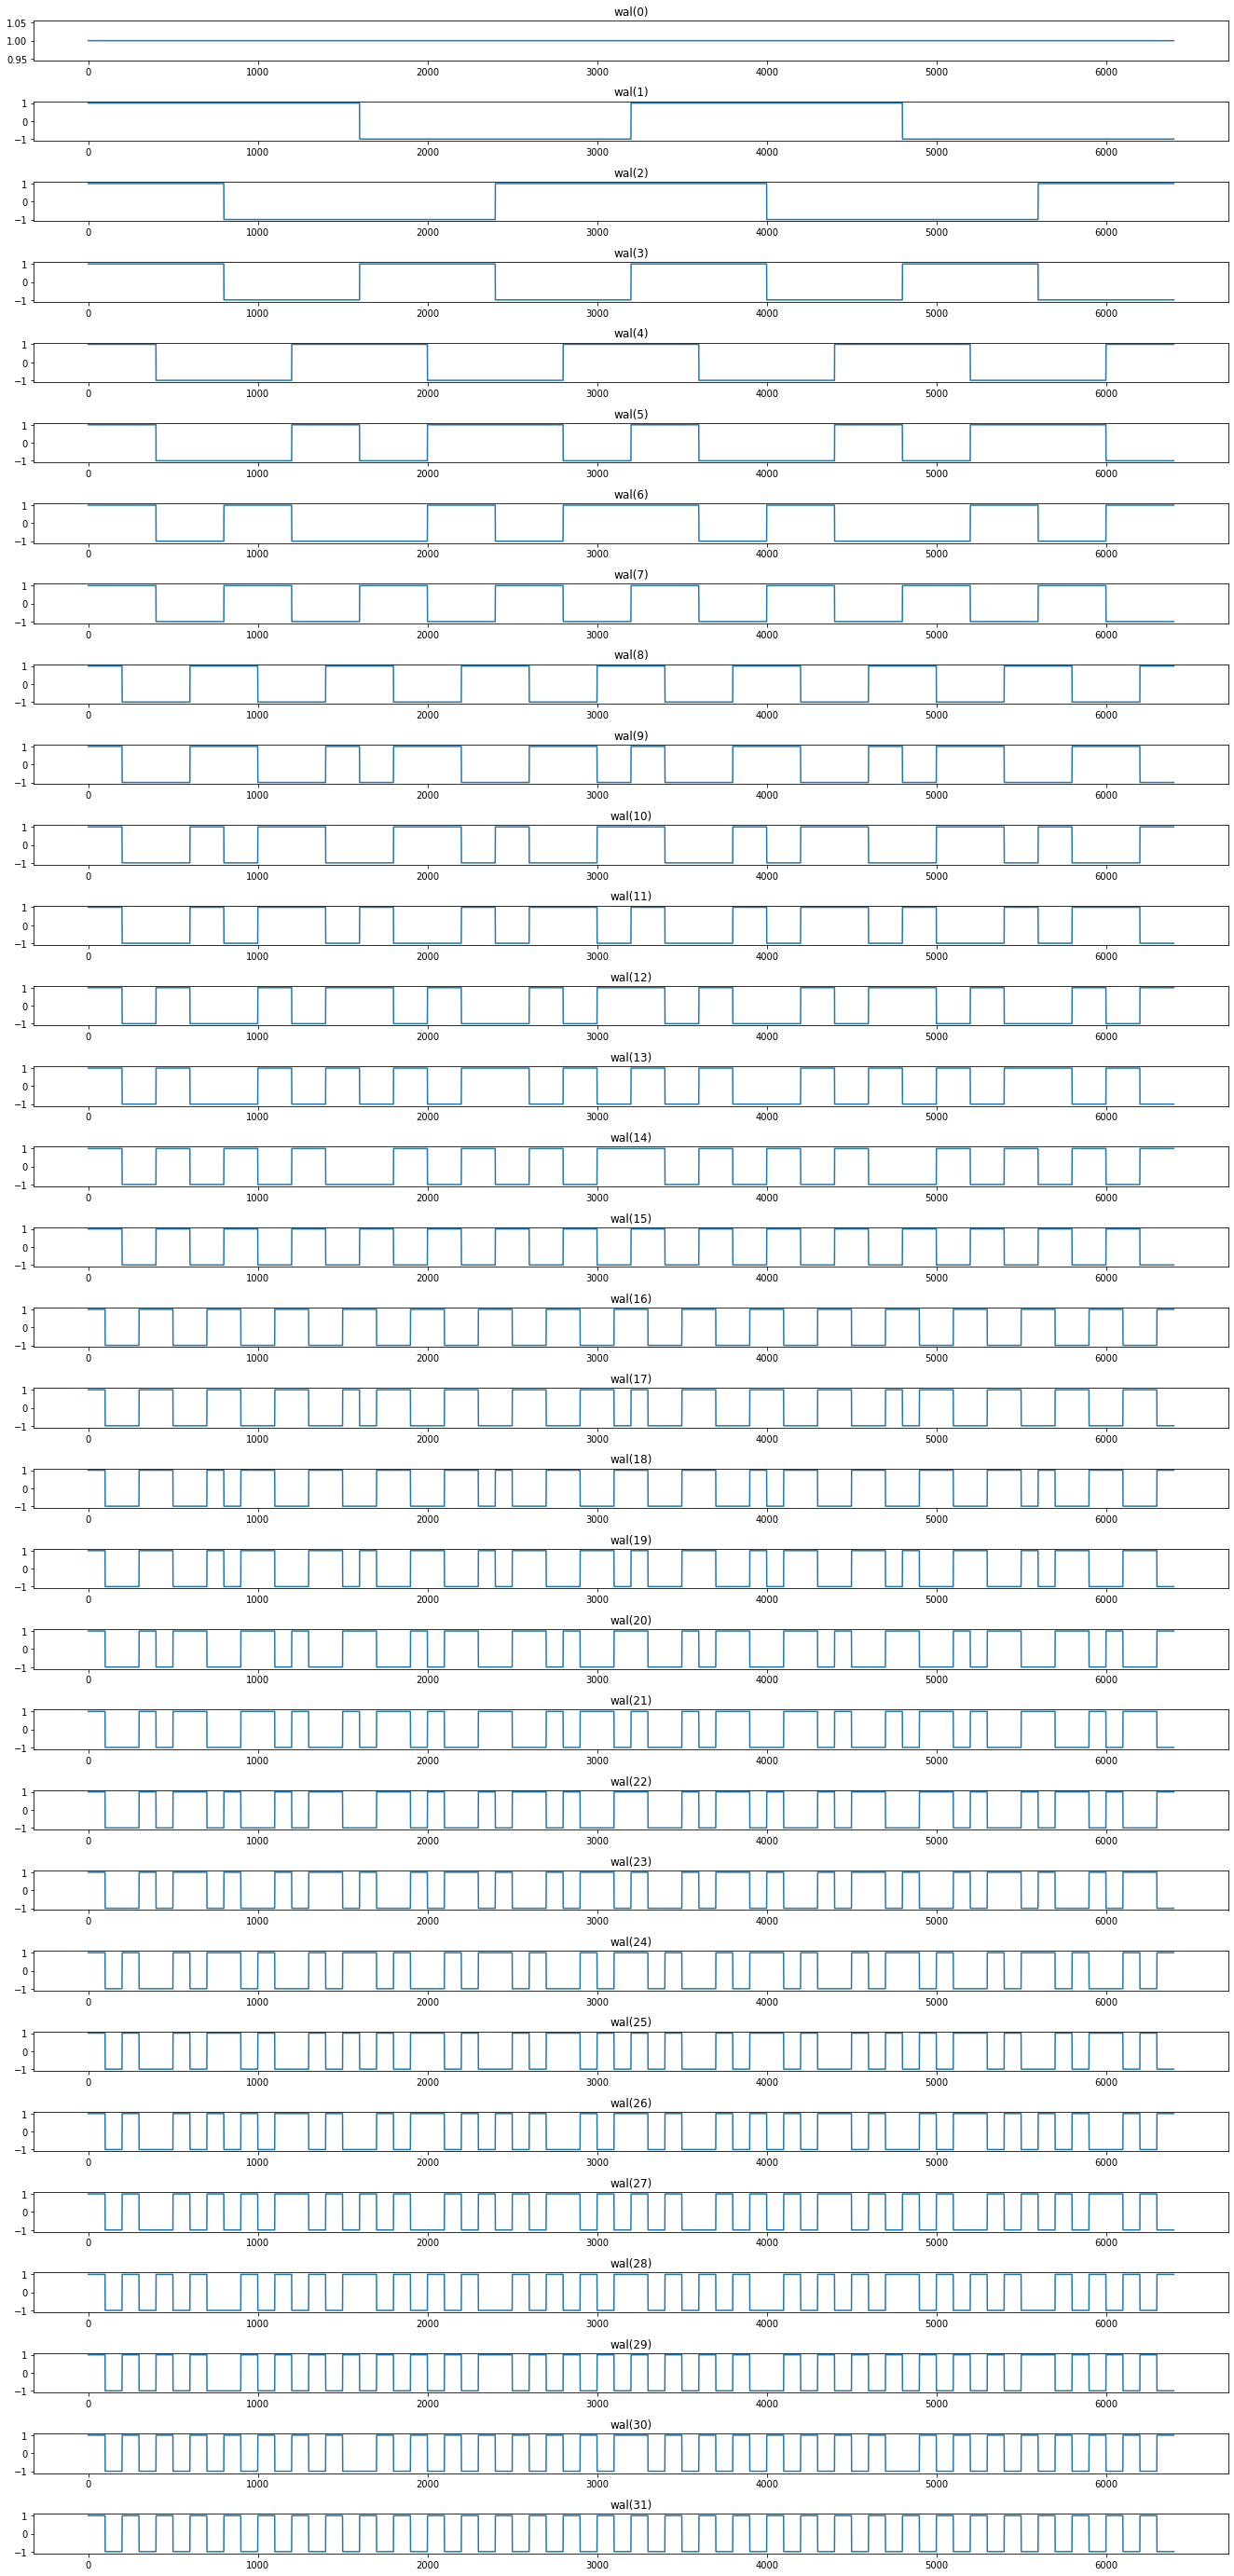

In [24]:
fig,ax = plt.subplots(32,1)
fig.set_size_inches(18.5, 38.5)
for i in range(32):
    ax[i].plot(doubled[i])
    ax[i].set_title('wal('+str(i)+')')
plt.tight_layout()
plt.show()

reorder by number of zero crossings

shift by 1% of the shortest element (1), cross correlate, integrate over T

In [25]:
np.set_printoptions(threshold=np.inf)
crosstalk = np.zeros((32,32))
for i in range(32):
    shifted = doubled[i][1:3201]
    for j in range(32):
        stable = doubled[j][0:3200]
        crossprod = shifted*stable 
        resid = np.sum(crossprod)
        crosstalk[i,j] = resid/3200

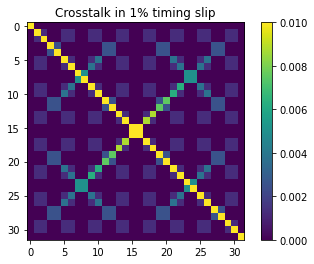

In [26]:
plt.figure()
fig.set_size_inches(18.5, 10.5)
plt.imshow(abs(crosstalk),vmax=.01)
plt.title('Crosstalk in 1% timing slip')
plt.colorbar()
fig.set_size_inches(18.5, 18.5)
plt.savefig('crosstalk_matrix', format='pdf')

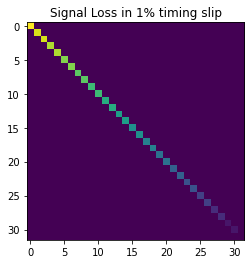

In [27]:
plt.figure()
plt.imshow(crosstalk,vmin=.98)
plt.title('Signal Loss in 1% timing slip')
fig.set_size_inches(18.5, 18.5)

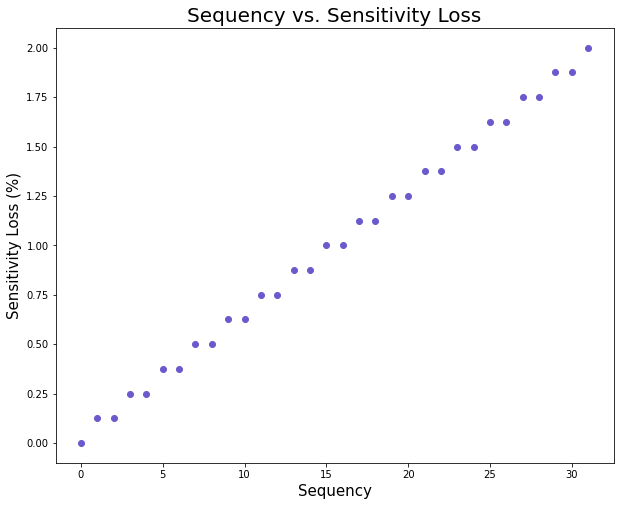

In [28]:
plt.figure(figsize=(10,8))
for i in range(32):
    for j in range(32):
        if i==j:
            plt.title('Sequency vs. Sensitivity Loss',fontsize=20)
            plt.scatter(sorted_inds[i],((1-crosstalk[i][j])*100), c='slateblue')
            plt.xlabel('Sequency',fontsize=15)
            plt.ylabel('Sensitivity Loss (%)', fontsize=15)
plt.savefig('Sensitivity_loss.pdf',format='pdf')

In [29]:
#RSS Crosstalk
rss = []
for i in range(32):
    summed = 0 
    for j in range(32):
        if i==j:
            pass
        else:
            summed += (crosstalk[i][j])**2
    rss.append(np.sqrt(summed)*100)

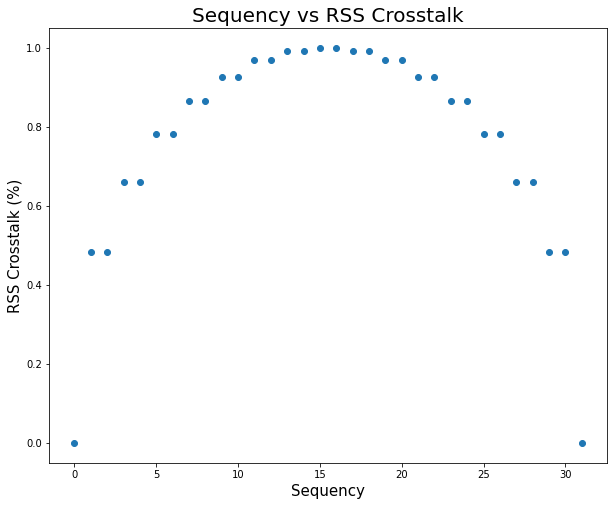

In [30]:
plt.figure(figsize=(10,8))
plt.title('Sequency vs RSS Crosstalk', fontsize=20)
plt.xlabel('Sequency', fontsize=15)
plt.ylabel('RSS Crosstalk (%)', fontsize=15)
plt.scatter(sorted_inds,rss)
plt.savefig('rsscrosstalk.pdf',format='pdf')

# What if the phase switch has an amplitude imbalance?

Instead of 1, -1, assume a 1% amplitude loss along the 180 degree path. no time shift. 

In [31]:
imbalanced_walsh = np.zeros_like(doubled)

for i in range(32):
    for j in range(len(imbalanced_walsh[i])):
        if doubled[i][j] == 1:
            imbalanced_walsh[i][j] = 1
        if doubled[i][j] == -1:
            imbalanced_walsh[i][j] = -.99

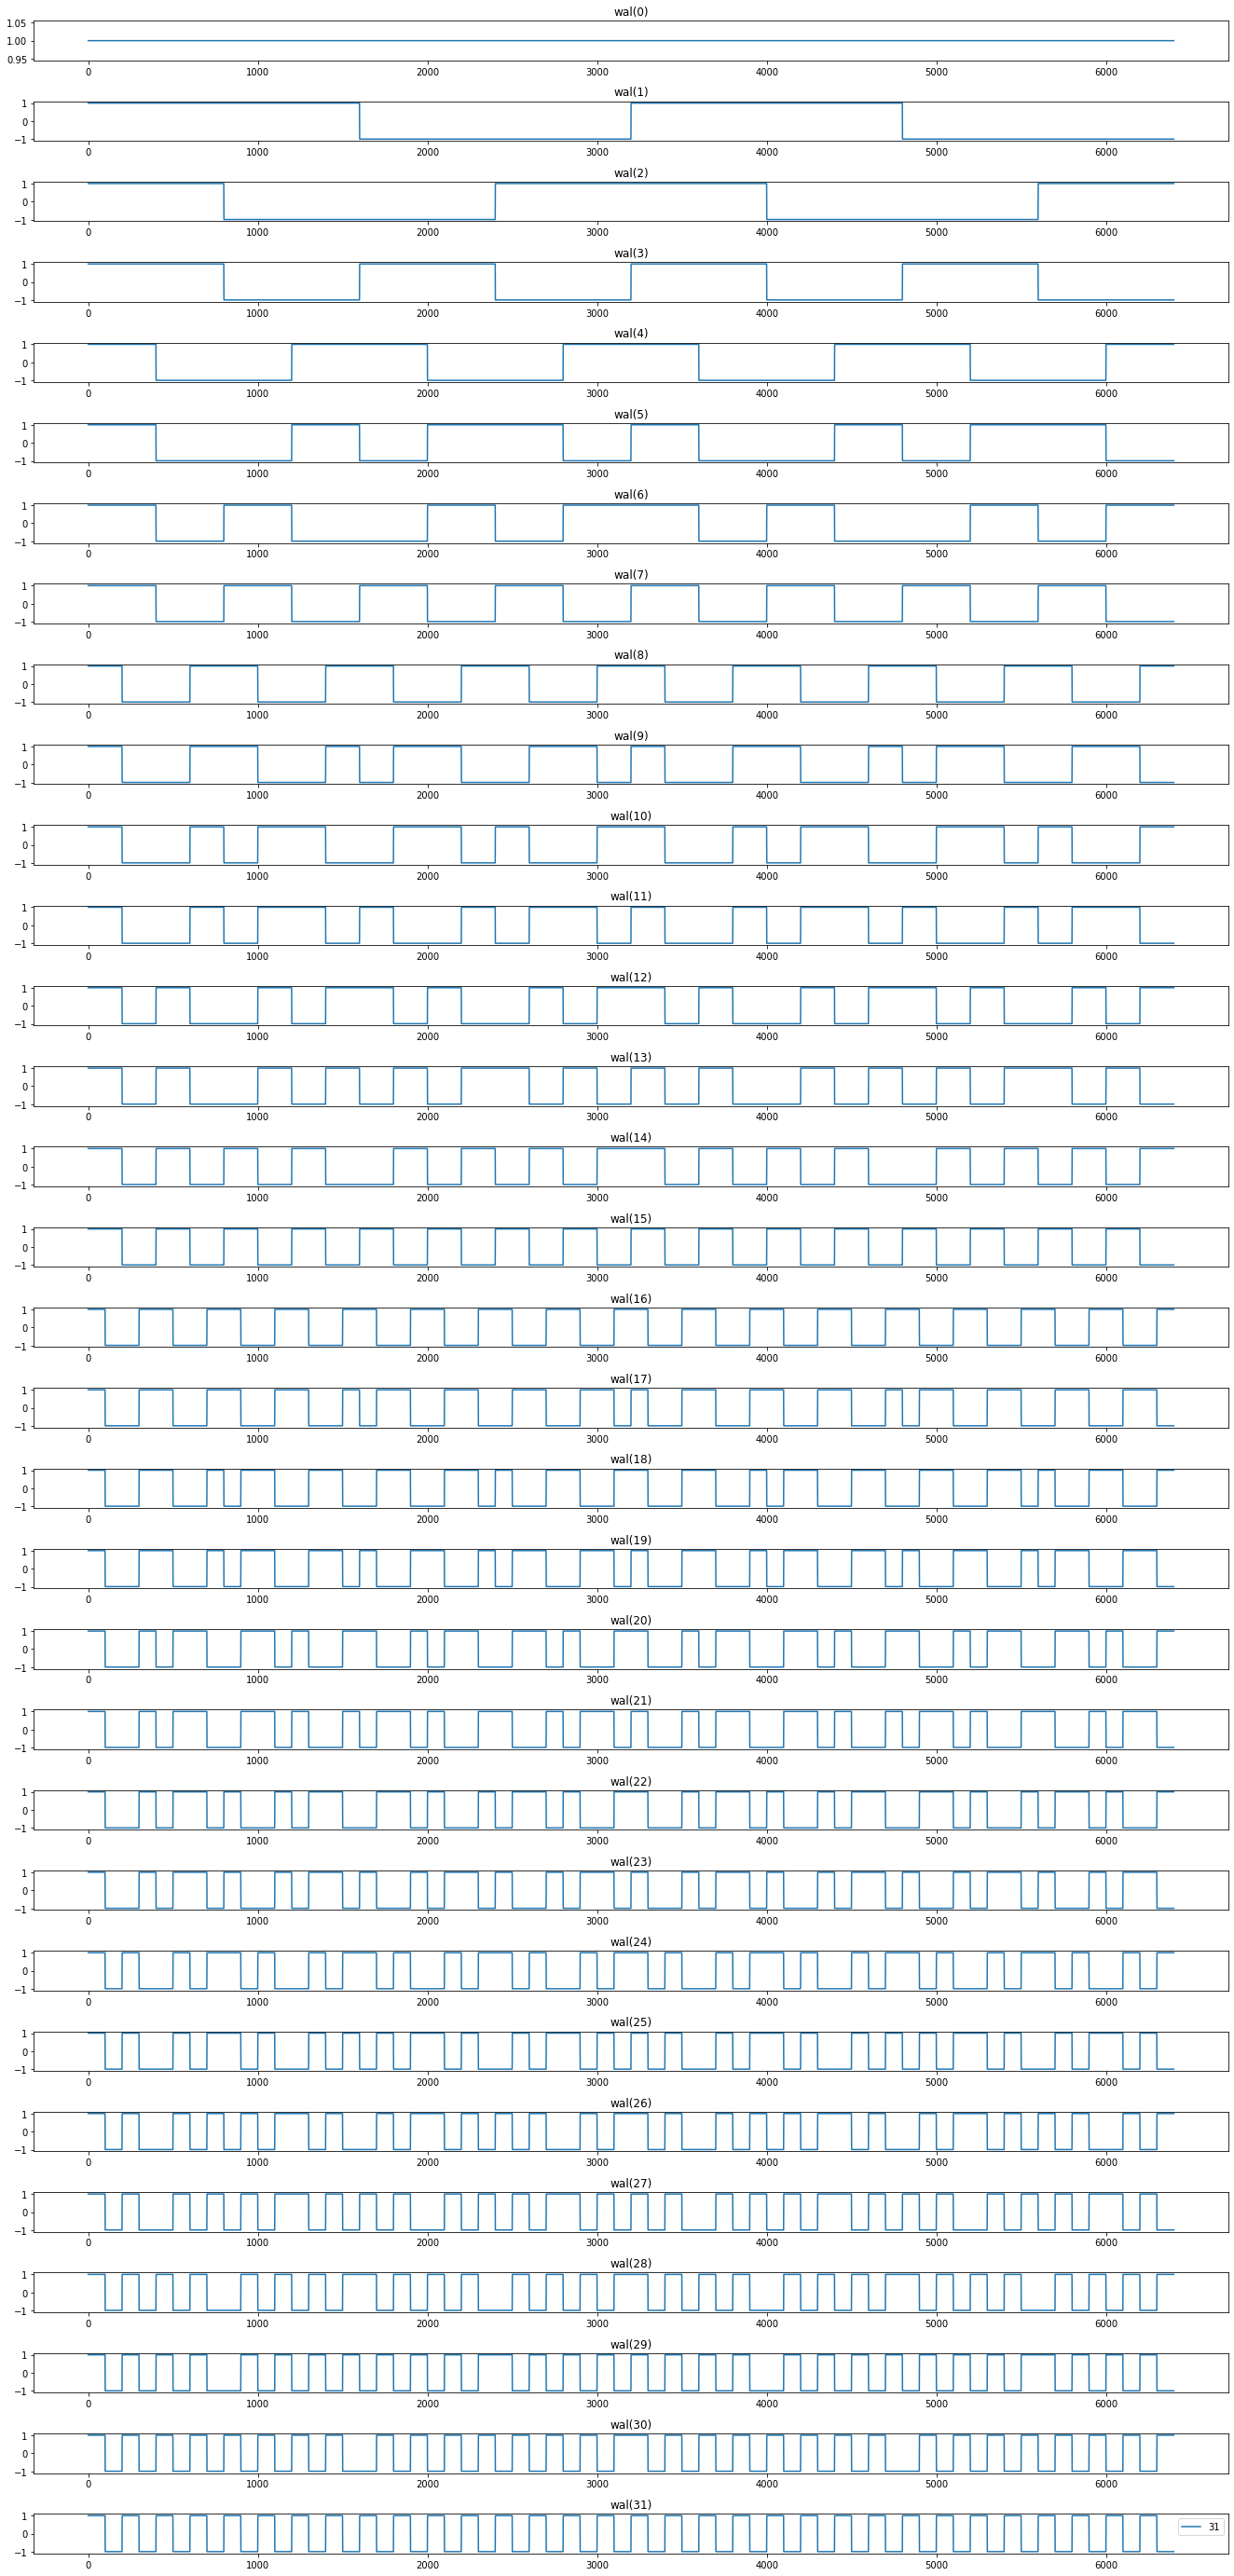

In [32]:
fig,ax = plt.subplots(32,1)
fig.set_size_inches(18.5, 38.5)
for i in range(32):
    ax[i].plot(imbalanced_walsh[i], label=i)
    ax[i].set_title('wal('+str(sorted_inds[i])+')')
plt.legend()
plt.tight_layout()
plt.show()

In [33]:
crosstalkimb = np.zeros((32,32))
for i in range(32):
    shifted = imbalanced_walsh[i][0:3200]
    for j in range(32):
        stable = doubled[j][0:3200]
        crossprod = shifted*stable 
        resid = np.sum(crossprod)
        crosstalkimb[i,j] = resid/3200

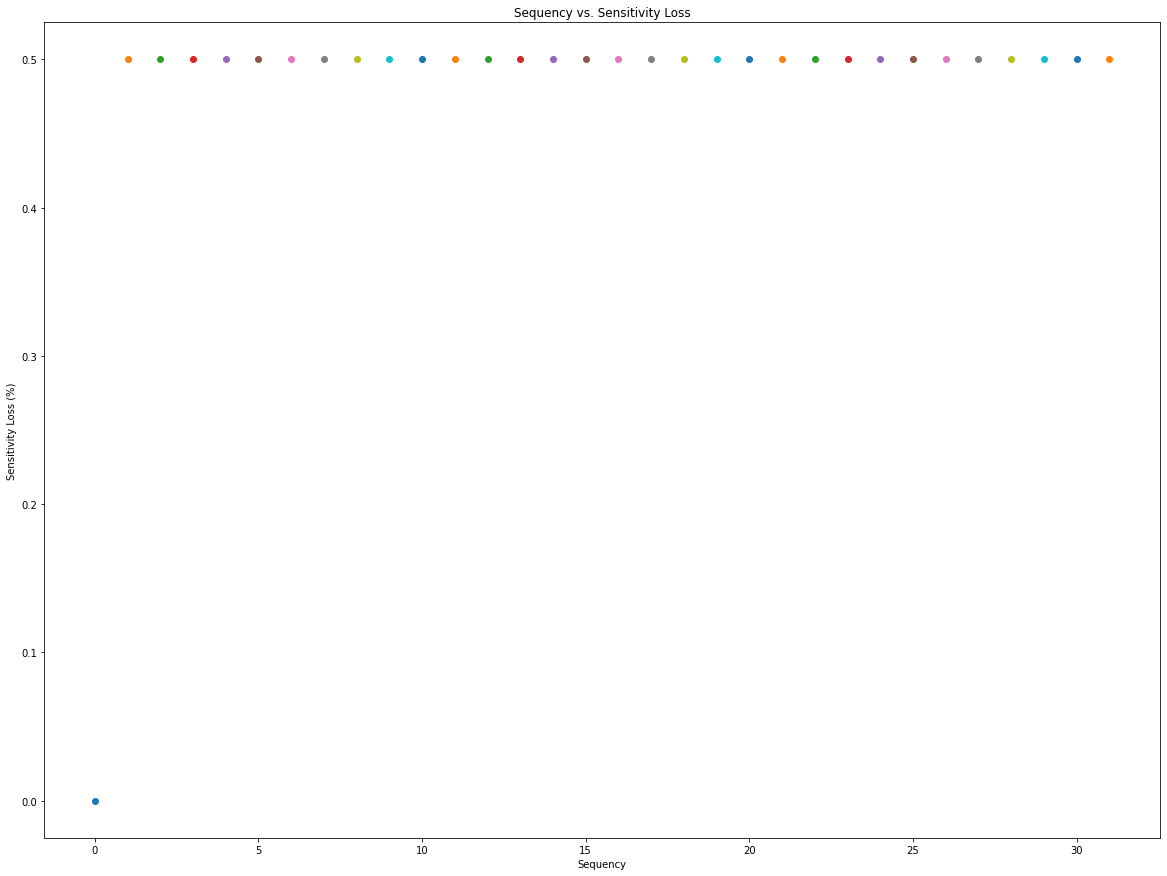

In [34]:
plt.figure(figsize=(20,15))
for i in range(32):
    for j in range(32):
        if i==j:
            plt.title('Sequency vs. Sensitivity Loss')
            plt.scatter(sorted_inds[i],((1-crosstalkimb[i][j])*100))
            plt.xlabel('Sequency')
            plt.ylabel('Sensitivity Loss (%)')

In [35]:
#RSS Crosstalk
rssimb = []
for i in range(32):
    summed = 0 
    for j in range(32):
        if i==j:
            pass
        else:
            summed += (crosstalkimb[i][j])**2
    rssimb.append(np.sqrt(summed)*100)

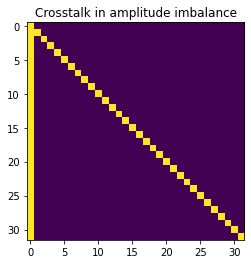

In [36]:
plt.figure()
fig.set_size_inches(18.5, 10.5)
plt.imshow(crosstalkimb,  vmax=.001)
plt.title('Crosstalk in amplitude imbalance')
fig.set_size_inches(18.5, 18.5)

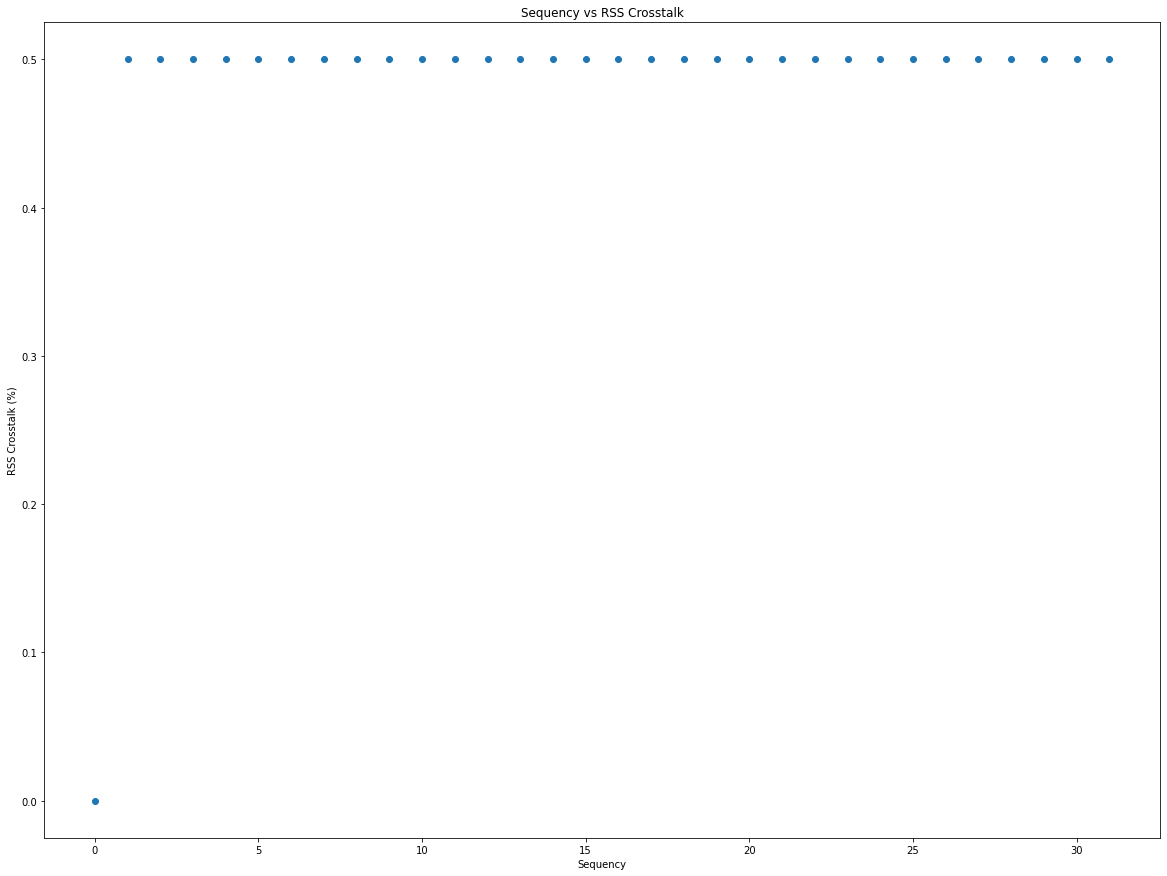

In [37]:
plt.figure(figsize=(20,15))
plt.title('Sequency vs RSS Crosstalk')
plt.xlabel('Sequency')
plt.ylabel('RSS Crosstalk (%)')
plt.scatter(sorted_inds,rssimb)

# How about a varying signal?


Try to replicate ALMA memo 565 appendix

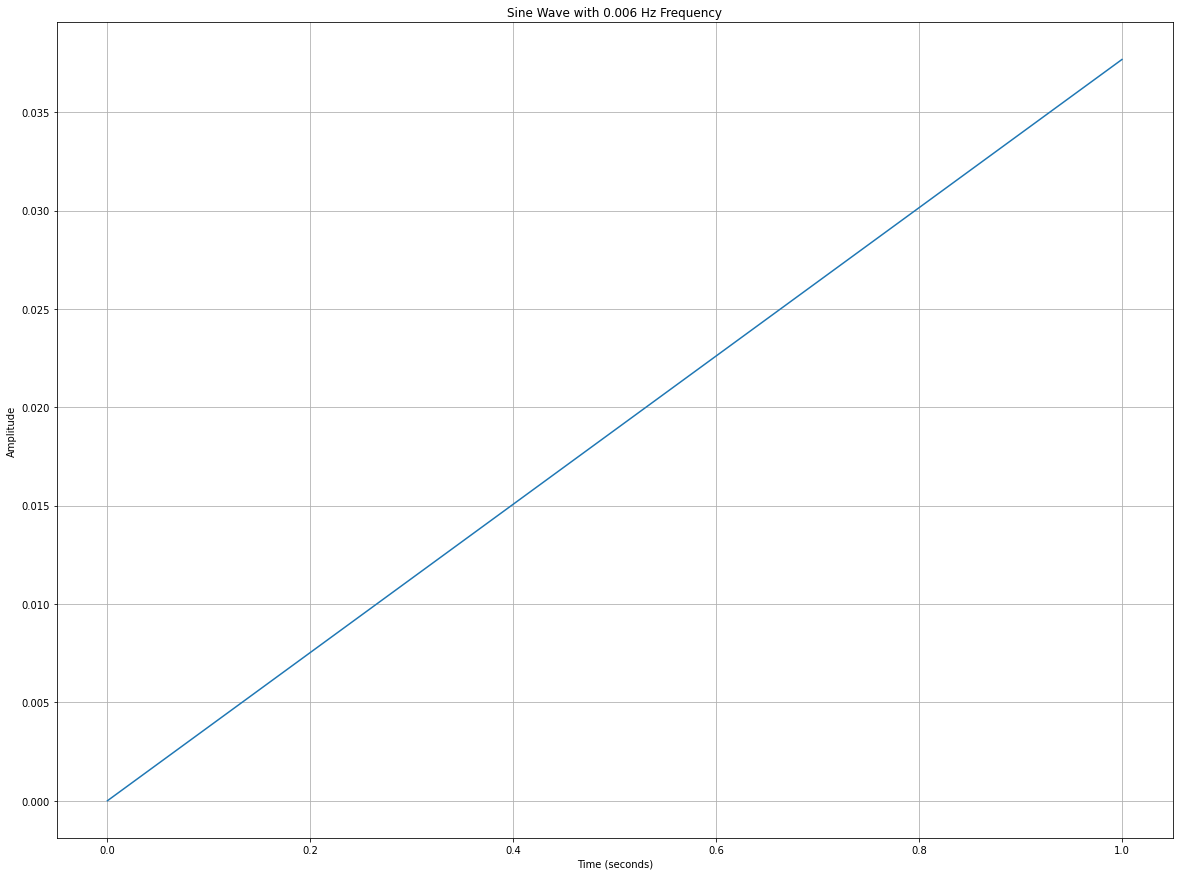

In [38]:
# Set the parameters
frequency = 0.006  # Frequency of the sine wave in Hz
duration = 1  # Duration of the signal in seconds
sampling_rate = 3200  # Sampling rate in Hz

t = np.arange(0, duration, 1/sampling_rate)

# Generate the sine wave
sine_wave = np.sin(2 * np.pi * frequency * t)

plt.figure(figsize=(20,15))
plt.plot(t, sine_wave)
plt.title(f"Sine Wave with {frequency} Hz Frequency")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

In [39]:
crosstalk_single = []
for i in range(32):
    crosstalk = np.sum(sine_wave*doubled[i][0:3200])
    normed = crosstalk/3200
    crosstalk_single.append(normed)

In [40]:
print(crosstalk_single)

[0.018841434484115332, -0.009422825714051153, -8.36839743443285e-07, -0.004711308230969249, -2.0920412850955473e-07, 1.0462547547884782e-07, -4.184175487920161e-07, -0.0023556410376632197, -5.230066918058066e-08, 2.6156187355377143e-08, 2.3229273192482135e-12, 1.3077803253571523e-08, -1.0460191907639416e-07, 5.2312665134238154e-08, -2.0920848403153947e-07, -0.001177818884117548, -1.3075144611107356e-08, 6.539035494407611e-09, 5.807309581135067e-13, 3.269445140808083e-09, 1.4517880821129924e-13, -7.26054546346111e-14, 2.903636445866775e-13, 1.634713495063736e-09, -2.6150325516142643e-08, 1.3078089139808084e-08, 1.161462983081951e-12, 6.5388993575072464e-09, -5.230094139097724e-08, 2.6156323491531575e-08, -1.04604205720428e-07, -0.0005889092377199414]


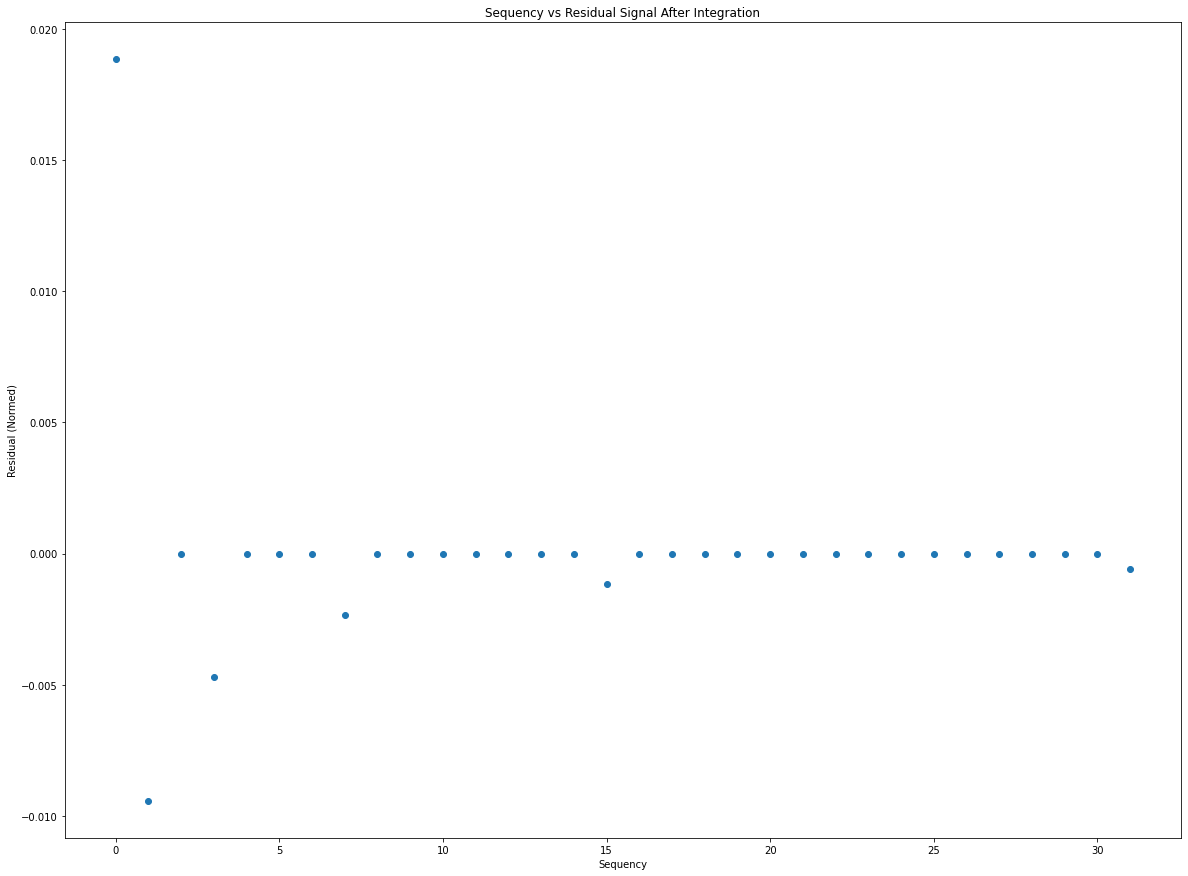

In [41]:
plt.figure(figsize=(20,15))
plt.title('Sequency vs Residual Signal After Integration')
plt.xlabel('Sequency')
plt.ylabel('Residual (Normed)')
plt.scatter(sorted_inds,crosstalk_single)

In [42]:
crosstalk = np.zeros((32,32))
for i in range(32):
    for j in range(32):
        mult1 = doubled[i][0:3200]*sine_wave
        mult2 = doubled[j][0:3200]*sine_wave
        crossprod = mult1*mult2
        resid = np.sum(crossprod)
        crosstalk[i,j] = resid/3200

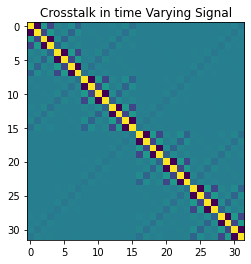

In [43]:
plt.figure()
fig.set_size_inches(18.5, 10.5)
plt.imshow(crosstalk)
plt.title('Crosstalk in time Varying Signal')
fig.set_size_inches(18.5, 18.5)

In [44]:
rss = []
for i in range(32):
    summed = 0 
    for j in range(32):
        if i==j:
            pass
        else:
            summed += (crosstalk[i][j])**2
    rss.append(np.sqrt(summed)*100)

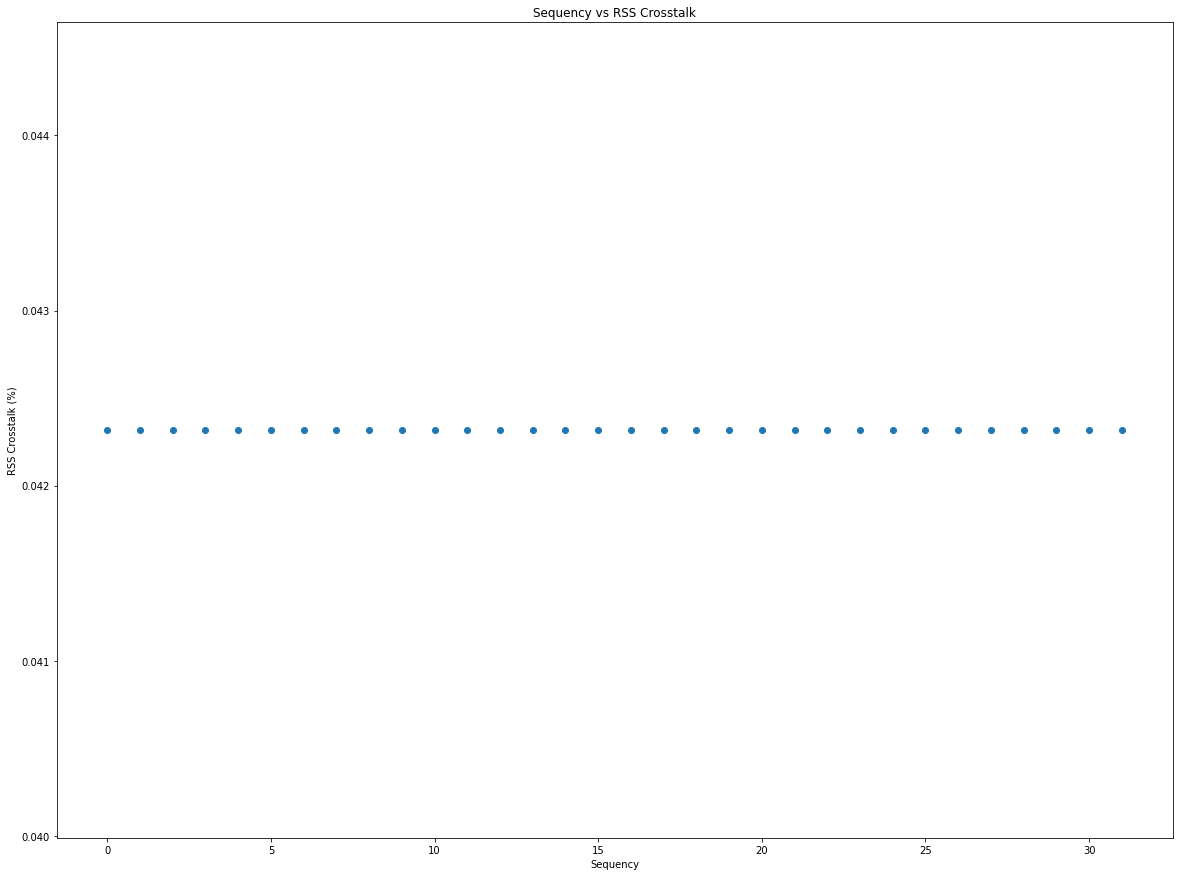

In [45]:
plt.figure(figsize=(20,15))
plt.title('Sequency vs RSS Crosstalk')
plt.xlabel('Sequency')
plt.ylabel('RSS Crosstalk (%)')
plt.scatter(sorted_inds,rss)